>### Image Enhancement 순서
- 1) 원본 이미지 생성 또는 불러오기
    - 초음파 이미지를 생성하거나 불러옵니다.

- 2) 이미지 세그멘테이션 수행
    - 이미지 세그멘테이션 모델을 사용하여 원본 이미지의 객체 구조를 예측합니다.

- 3) 노이즈 추가
    - 이미지 세그멘테이션 이후에 노이즈를 추가합니다.
    - 이미지 세그멘테이션 결과를 보존하면서 노이즈를 추가해야 합니다.

- 4) 모델 학습 및 평가
    - 세그멘테이션된 이미지와 노이즈가 추가된 이미지를 사용하여 모델을 학습하고 평가합니다.

>### Ready to Dependancy

In [2]:
## Import and Ready
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pydicom
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array, load_img

AUTOTUNE = tf.data.AUTOTUNE

>### One sample visualization

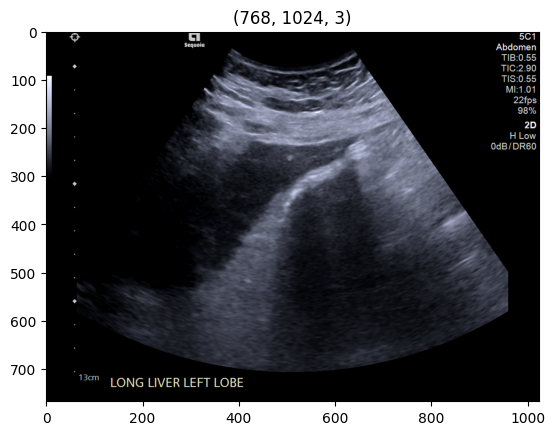

In [3]:
dicom_file_path = r"C:\Users\sel04327\PycharmProjects\IQ_improvement\Test_imgs\test3.dcm"
dicom_data = pydicom.dcmread(dicom_file_path)

img_data = dicom_data.pixel_array

# 이미지 출력
plt.imshow(img_data, cmap='gray')
plt.title(img_data.shape)
plt.show()

>### 1) 원본 이미지 생성 또는 불러오기

In [4]:
from multiprocessing import Pool

class DownConvert:
    """Dicom file download and convert to np.array data to output location"""
    
    def __init__(self, input_path, output_path, num_files):
        
        self.input_path = input_path
        self.output_path = output_path
        self.num_files = num_files
        
        # 이미지를 저장할 폴더가 없으면 생성
        if not os.path.exists(self.output_path):
            os.makedirs(self.output_path)
        

    def convert_dicom2np(self, file_path):
        """DICOM 파일 읽기 / 추출 / numpy 저장"""
        dicom_data = pydicom.dcmread(file_path) 
        image_data = dicom_data.pixel_array             # DICOM 이미지 데이터 추출

        # 이미지 출력
        # plt.imshow(image_data, cmap='gray')
        # plt.title('DICOM Image')
        # plt.show()
    
        image_array = np.array(image_data)              # 이미지 데이터 numpy로 저장
        output_file_location = os.path.join(self.output_path, f"{os.path.basename(file_path)[:-4]}.npy")
        np.save(output_file_location, image_array)          # 변환된 NumPy 배열을 저장
        

    def join_folder_file(self, folder_path):
        """Each folder를 다 검색하여, file list로 저장."""
        # 폴더 내 DICOM 파일 목록
        dicom_files = [arr_file for arr_file in os.listdir(folder_path) 
                    if arr_file.endswith('.dcm')]  
        
        with Pool() as pool:
            # convert_dicom2np 함수를 호출하여 각 파일을 처리
            pool.map(self.convert_dicom2np, [os.path.join(folder_path, file_name) for file_name in dicom_files])


    def search_dicom_folders(self):
        """메인 폴더 내의 모든 하위 디렉토리를 검색하고 각 폴더에서 내가 원하는 파일 갯수만큼만 처리"""
        subfolders = [f.path for f in os.scandir(self.input_path) if f.is_dir()]

        # 각 하위 디렉토리에 대해 DICOM 파일 처리
        with Pool() as pool:
            # Pass the instance along with file paths
            pool.starmap(self.join_folder_file, [(subfolder,) for subfolder in subfolders])



# 메인 폴더에서 DICOM 파일을 처리하고자 하는 함수 호출
input_path = r'\\157.226.12.150\IQH-Public\AdvDevNTOS\External_Collaborators_Images'
output_path = r'C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files'

In [5]:
down_convert = DownConvert(input_path=input_path, output_path=output_path, num_files=5)
down_convert.search_dicom_folders()

In [19]:
def convert_dicom2np(file_path, output_path):
    """DICOM 파일을 NumPy 배열로 변환하여 저장"""
    dicom_data = pydicom.dcmread(file_path)
    image_data = dicom_data.pixel_array
    np.save(output_path, image_data)

def convert_folder_to_np(input_folder, output_folder, num_files=None):
    """폴더 내의 일부 또는 모든 DICOM 파일을 NumPy 배열로 변환하여 저장"""
    # 폴더가 없으면 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    total_files_cnt = 0
    for root, dirs, files in os.walk(input_folder):
        dicom_files = [file_name for file_name in files] ## if file_name.endswith('.dcm')]
        dicom_file_cnt = len(dicom_files)

        if dicom_file_cnt > 0:

            if num_files is not None:
                dicom_files = dicom_files[:num_files]

            for file_name in dicom_files:
                file_path = os.path.join(root, file_name)
                output_path = os.path.join(output_folder, f"{os.path.splitext(file_name)[0]}.npy")
                
                print(file_path, output_path)
                convert_dicom2np(file_path, output_path)
                
                total_files_cnt += 1
                print(total_files_cnt)
                if num_files is not None and total_files_cnt >= num_files:
                    break   ##현재 처리한 파일 갯수가 num_files을 넘는지 확인
            
            if num_files is not None and total_files_cnt >= num_files:
                break ##전체 처리한 파일 갯수가 num_files을 넘는지 확인

# 사용 예시: 파일 갯수를 선택해서 변환 (예: 5개)
input_folder = r'\\157.226.12.150\IQH-Public\AdvDevNTOS\External_Collaborators_Images'
output_folder = r'C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files'

num_files_to_process = 100
convert_folder_to_np(input_folder, output_folder, num_files=num_files_to_process)

\\157.226.12.150\IQH-Public\AdvDevNTOS\External_Collaborators_Images\Dr. Barr\00\I1000001 C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files\I1000001.npy
1
\\157.226.12.150\IQH-Public\AdvDevNTOS\External_Collaborators_Images\Dr. Barr\00\I1000003 C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files\I1000003.npy
2
\\157.226.12.150\IQH-Public\AdvDevNTOS\External_Collaborators_Images\Dr. Barr\00\I1100000 C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files\I1100000.npy
3
\\157.226.12.150\IQH-Public\AdvDevNTOS\External_Collaborators_Images\Dr. Barr\00\I1100001 C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files\I1100001.npy
4
\\157.226.12.150\IQH-Public\AdvDevNTOS\External_Collaborators_Images\Dr. Barr\00\I1200000 C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files\I1200000.npy
5
\\157.226.12.150\IQH-Public\AdvDevNTOS\External_Collaborators_Images\Dr. Barr\00\I1200001 C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files\I1200001.npy
6
\\157.226.12.150\IQH-P

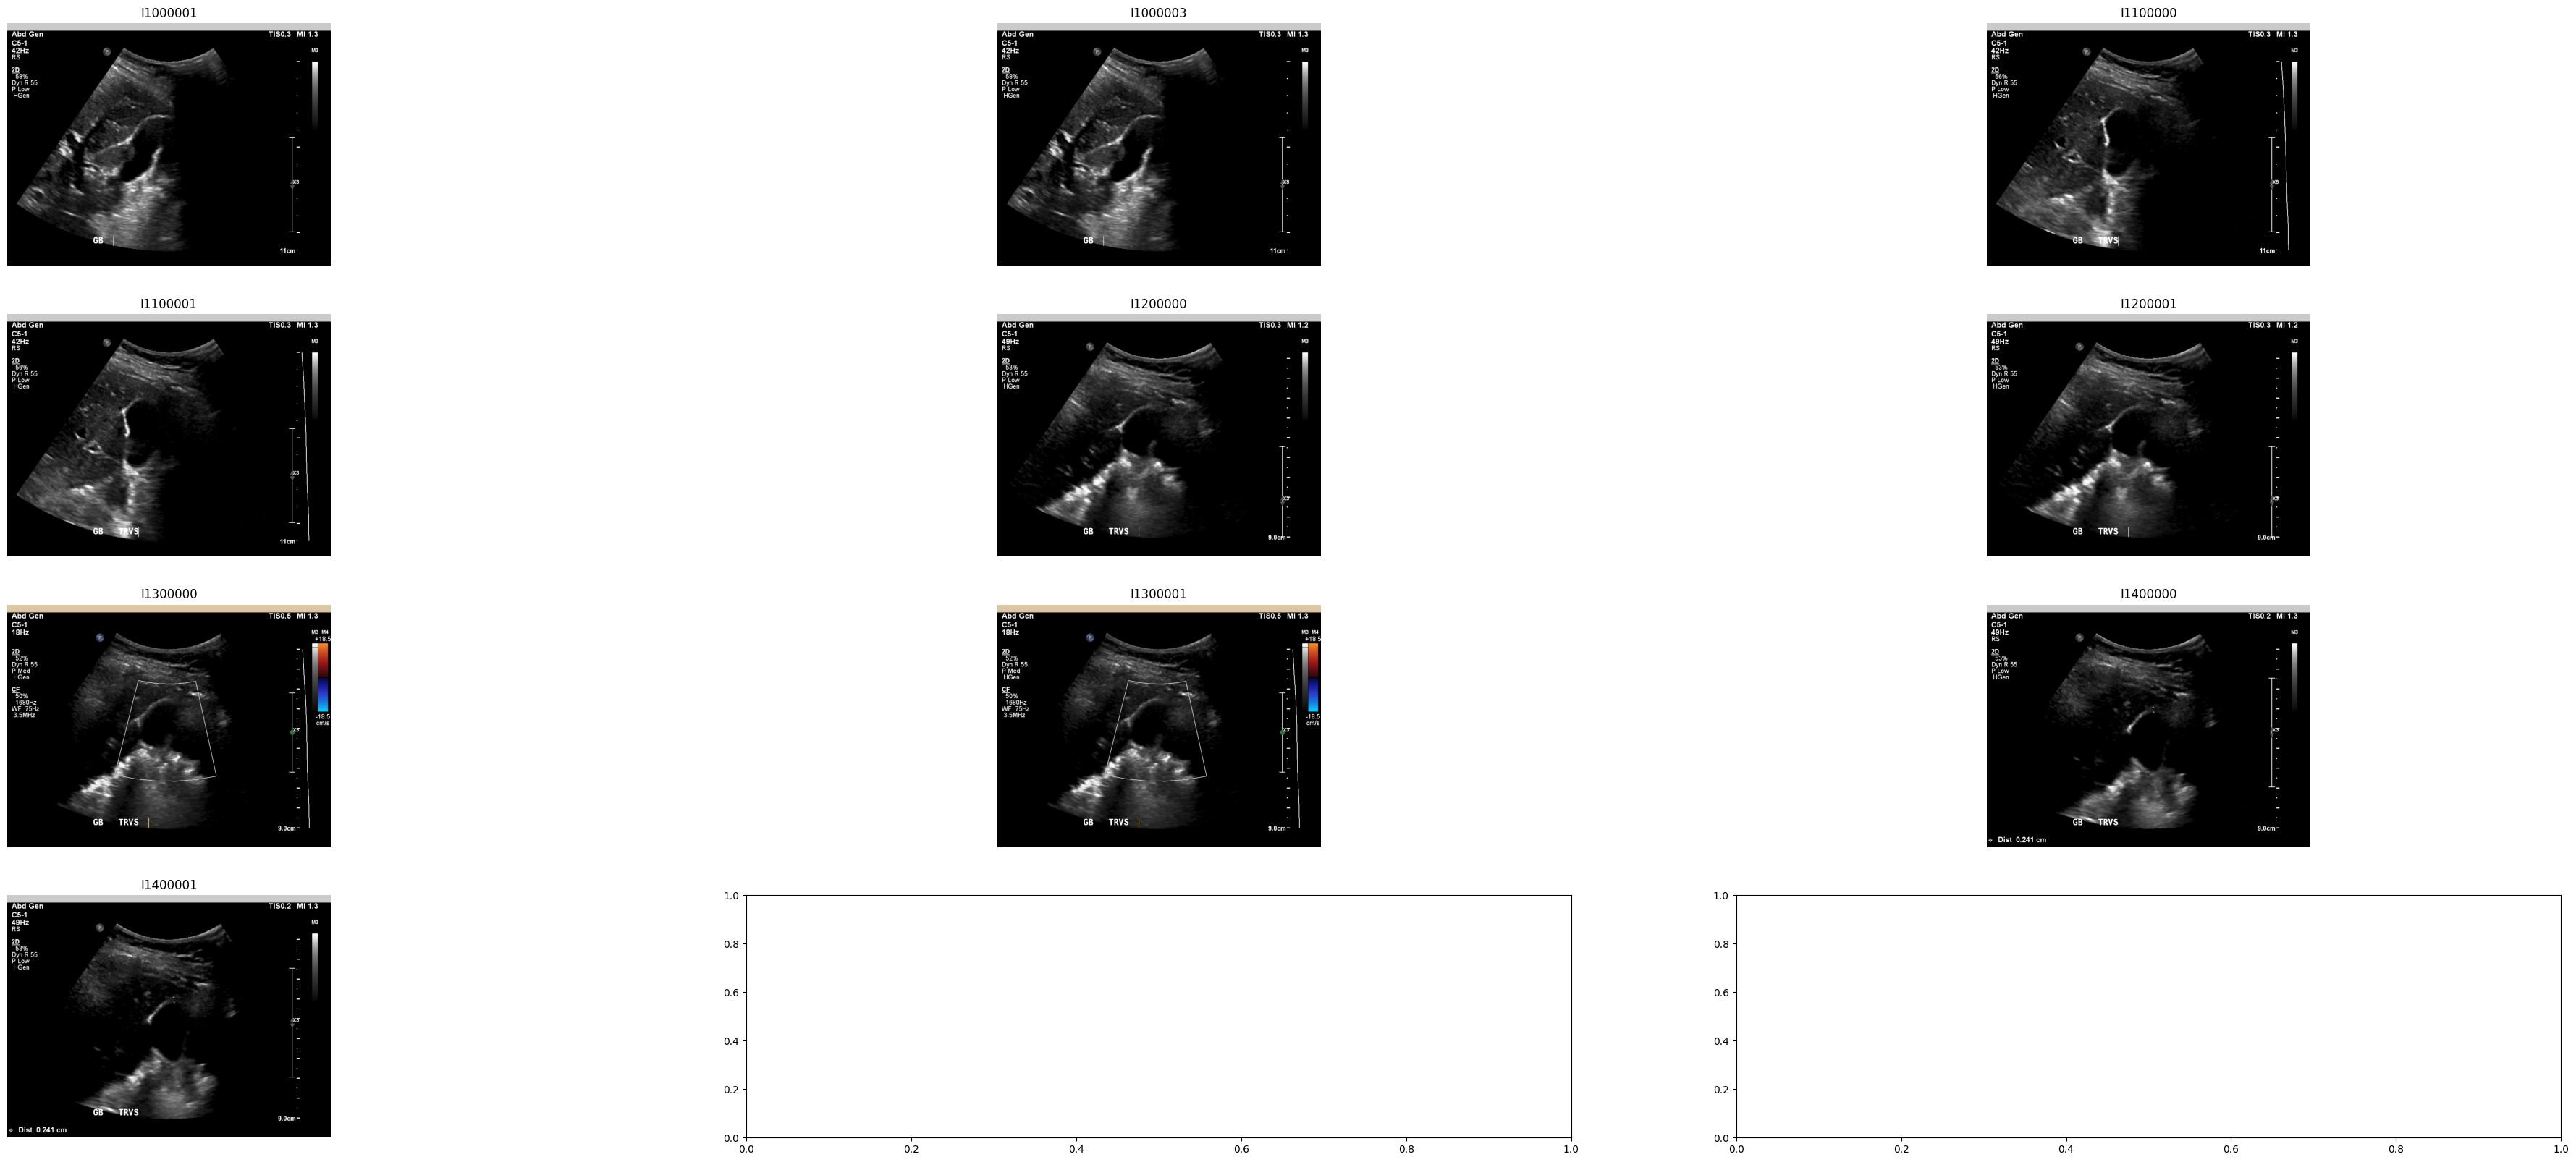

In [38]:
def plot_numpy_array_subplot(numpy_arrays, titles, num_rows, num_cols):
    """여러 개의 NumPy 배열을 subplot을 이용하여 플로팅"""
    num_plots = len(numpy_arrays)

    if num_plots > 0:
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(50, 20))

        for i in range(num_plots):
            row_index = i // num_cols
            col_index = i % num_cols

            axs[row_index, col_index].imshow(numpy_arrays[i], cmap='gray')
            axs[row_index, col_index].set_title(titles[i])
            axs[row_index, col_index].axis('off')

        plt.show()

def plot_np_files_in_folder_subplot(folder_path, num_files, num_files_per_row=5):
    """폴더 내의 NumPy 배열 파일을 읽어와서 subplot을 이용하여 플로팅"""
    np_files = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.npy')]

    numpy_arrays = []
    titles = []

    for file_name in np_files[:num_files]:
        file_path = os.path.join(folder_path, file_name)
        numpy_array = np.load(file_path)
        numpy_arrays.append(numpy_array)
        titles.append(f"{os.path.splitext(file_name)[0]}")

    num_rows = (len(numpy_arrays) // num_files_per_row) + 1
    num_cols = min(len(numpy_arrays), num_files_per_row)

    plot_numpy_array_subplot(numpy_arrays, titles, num_rows, num_cols)

# 사용 예시: 폴더 내의 NumPy 배열 파일 subplot 플로팅 (모든 파일)
folder_path = r'C:\Users\sel04327\PycharmProjects\IQ_improvement\np_files'
plot_np_files_in_folder_subplot(folder_path, num_files=10, num_files_per_row=3)
